<a href="https://colab.research.google.com/github/CharlesBlack96/s13mod2/blob/main/s13mod2_Vector_Representations_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

In [1]:
!python -m spacy download en_core_web_md

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-19 16:37:40.939179: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


##0.2 Restart Runtime

## 0.3 Imports

In [2]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [3]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1693, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1693 (delta 89), reused 124 (delta 72), pack-reused 1531
Receiving objects: 100% (1693/1693), 59.40 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (258/258), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist" 

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar. 
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [5]:
data_path = "/content/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data/job_listings.csv"         
df = pd.read_csv(data_path)

In [6]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need! 
* Don't spend more time than it takes to figure out how to remove html tags! 


In [10]:
def remove_html(text):
    """
    Extract text from html boiler plate code. 
    Converts bytes dtype into str dtype
    
    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/
    
    Parameters
    ----------
    text: string or object 
        contains text data that we want to clean
    
    Returns 
    -------
    text: str 
        cleaned text data ready for vectorization
    """
    
    # create soup object 
    soup = BeautifulSoup(text, 'html.parser')
    
    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string 
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  eval(soup.get_text())
    
    # if text is a byte data type, then convert to string 
    if isinstance(text, bytes):
        
        # convert byte data type into str
        text =  text.decode("utf-8")
        
    
    # use regex to clean your text data
    ###BEGIN SOLUTION
    text = re.sub("[^a-zA-Z]"," ",text)
    ###END SOLUTION
    
    # case normalize and strip extra white spaces on the far left and right hand side
    text = text.lower().lstrip().rstrip()


    return text

In [11]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))
# would this work? df["clean_text"] = df.description.apply(remove_html)

In [12]:
df.clean_text

0      job requirements  conceptual understanding in ...
1      job description  as a data scientist    you wi...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location  usa   multiple locations    years of...
                             ...                        
421    about us  want to be part of a fantastic and f...
422    internshipat uber  we ignite opportunity by se...
423    a yeara million people a year die in car colli...
424    senior data scientist job description  about u...
425    cerner intelligence is a new  innovative organ...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings 
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [13]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text. 
    Token filters are used to exclude low quality tokens.
    
    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token
    
    Input
    ----------
    text: string
        raw text document that needs to be tokenized
        
    Returns
    -------
    tokens: list of strings
    """
    doc = nlp(text)

    tokens = []

    for token in doc:
      if (token.is_stop != True) and (token.is_punct != True) and (token.is_space != True):
        tokens.append(token.lemma_)
    return tokens


### Apply our tokenizer function via `pandas.apply()`

In [14]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [15]:
df["lemmas"]

0      [job, requirement, conceptual, understanding, ...
1      [job, description, data, scientist, help, buil...
2      [data, scientist, work, consult, business, res...
3      [monthcontractunder, general, supervision, pro...
4      [location, usa, multiple, location, year, anal...
                             ...                        
421    [want, fantastic, fun, startup, s, revolutioni...
422    [internshipat, uber, ignite, opportunity, set,...
423    [yeara, million, people, year, die, car, colli...
424    [senior, datum, scientist, job, description, a...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function. 

In [17]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
vect = CountVectorizer(tokenizer=tokenizer, stop_words="english")
dtm_tf = vect.fit_transform(df.clean_text)# Here, tf stands for "term frequency, i.e. counts for each term"
dtm_tf = pd.DataFrame(data=dtm_tf.toarray(), columns=vect.get_feature_names_out())
###END SOLUTION

In [18]:
dtm_tf

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts in a barplot

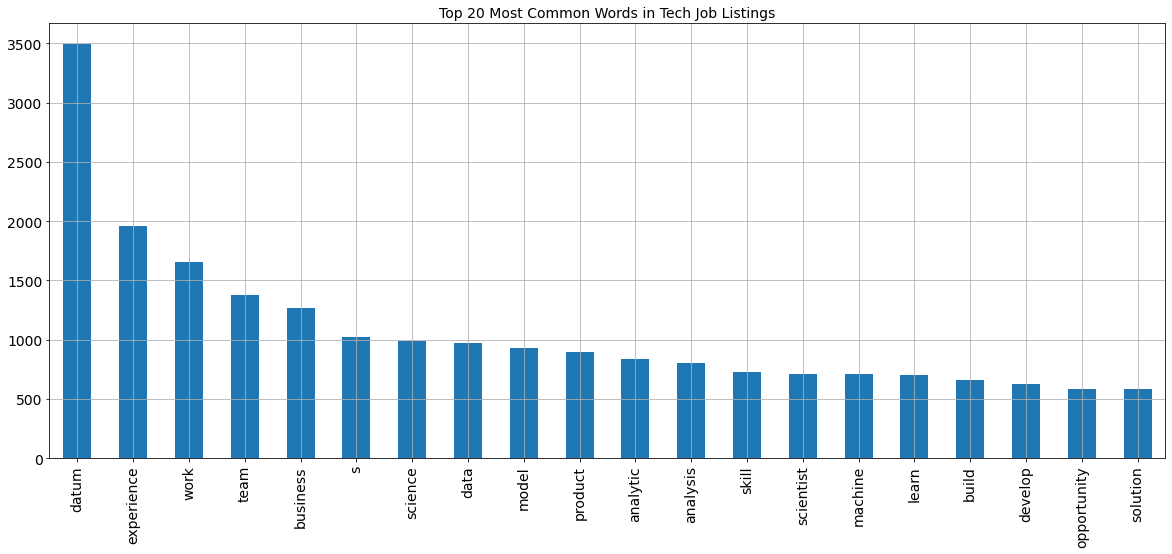

In [20]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum().sort_values(ascending=False)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
sorted_terms[:top_n].plot(kind="bar",figsize=(20,8),grid=True,fontsize=14)
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [24]:
###BEGIN SOLUTION
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

tfidf = tfidf.fit(df.clean_text)

dtm_tfidf = tfidf.transform(df.clean_text).toarray()

###END SOLUTION

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
dtm_tfidf_df = pd.DataFrame(data=dtm_tfidf, columns=vect.get_feature_names_out())

In [26]:
dtm_tfidf_df

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.091966,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.021737,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.070313,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.114166,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.029509,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.105362,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.000000,0.06671,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [27]:
ideal_ds_job_query=["""We are seeking a data scientist to join our business intelligence team to help us make better
 business decisions based on our data. The ideal candidate will have a working knowledge of statistics, mathematics, and
 data science programming languages (e.g., SQL, R, Python). Your primary responsibilities will be performing statistical analyses,
 running custom SQL queries,  and identifying patterns and trends that can improve our products’ and services’ efficiency and usability.
 You will also be expected to maintain and improve our data infrastructure and tools."""]

In [28]:
# vectorize your ideal job description using your fitted tfidf vectorizer 
ideal_job_vector = tfidf.transform(ideal_ds_job_query).toarray()

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
top_n_neigh = 3
nn = NearestNeighbors(n_neighbors=top_n_neigh)
nn.fit(dtm_tfidf)
# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
count=0
for most_sim_job_index in n_ind[:][0]:
  most_sim_job = df.clean_text.iloc[most_sim_job_index]
  count += 1
  print("/n",count," ", most_sim_job)


/n 1   if you re ready to innovate and help lead the development for hewlett packard enterprise s  hpe  analytics platform  come join us now  you will be part of an organization that is revolutionizing reporting solutions and architecting a data and analytics landscape that is simplified  modern  flexible and will ultimately enable hpe on its transformation journey and beyond  job overview  we are looking for a data scientist who will support our product  sales  leadership and marketing teams with insights gained from analyzing company data  the ideal candidate is adept at using large data sets to find opportunities for product and process optimization and using models to test the effectiveness of different courses of action  they must have strong experience using a variety of data mining data analysis methods  using a variety of data tools  building and implementing models  using creating algorithms and creating running simulations  they must have a proven ability to drive business re

## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.